In [13]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

dc = datacube.Datacube()
# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Sentinal 2 A&B Geomedian notebook

what does this notebook do? 

In [14]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], title='string', projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    title - string that the plot should be given as a title
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(title, fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [15]:
#set wet and dry month times

month_one= ('2016-02-01', '2016-03-05')
month_two= ('2017-10-01', '2017-12-31')

In [18]:

#set up peramiters for sentinal data loading

Ssensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want

Sbands_of_int =['red','blue','green'] #pick the sentinal bands that you want, here i am just using visible light  

Squery = {
        'lat': (-30.55, -30.65),
        'lon': (145.30, 145.40),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2016-02-01', '2016-02-28')
        }
# use s2b_ard_granule 	 for S2B
data = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **Squery)
data

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [10]:
#Temporal range, wavelengths/band and sensors of interest are defined for LANDSAT

Lsensors= ['ls8_nbart_albers'] #pick the landsat satelites you want

Lbands_of_int =['red','blue','green'] #pick the sentinal bands that you want, here i am just using visible light  

Lquery = {
        'lat': (-30.55, -30.65),
        'lon': (145.30, 145.40),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time':('2017-01-01', '2018-01-30')
        }

# this quiery retreives our data request entered in above cell

#data_land = dc.load(product='ls8_nbart_albers', group_by='solar_day',  **Lquery)

#data_land

In [11]:
data_sent_first = {}

sensors_used = 0

for i in Ssensors:
    try:
        this_sensor = s2aws.load(product= i, group_by='solar_day', **Squery)
    
        #retreive projection infromation
        crs = this_sensor.crs
        crswkt = this_sensor.crs.wkt
        affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
        clear_pixels = this_sensor.pixel_quality == 1
        clear_data = this_sensor.where(clear_pixels)
    
        data_sent_first[i] = this_sensor 
        sensors_used = sensors_used + 1
        print(i+' done')
    except:
        print(i+'dose not have any imagry for this time')

s2a_ard_granuledose not have any imagry for this time
s2b_ard_granuledose not have any imagry for this time


In [6]:
#concatinate all of the sentinal data together into one xarray, ordered by time, if you have more than one sensor!!
if sensors_used == 2:

    data_sent_first = xr.concat(data_sent.values(),'time')
    data_sent_first = data_sent.sortby('time')
    data_sent_first.attrs['crs'] = crs
    data_sent_first.attrs['affin|e'] = affine
    
    print('sucsessful concatination')
    
else:
    print('sensors equal ' + str(sensors_used) + ' no concat occured')

sensors equal 0 no concat occured


In [7]:
data_sent_first

{}

In [9]:
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')
#data_land_flt = data_land.astype(float,casting='safe')

In [10]:
#create slice of sentinal data which is only from the wet month

wet_gm = data_sent_flt.sel(time=slice('2015-07-01', '2015-09-30'))

In [11]:
#create geomedian for data
Sentinal_gm_wet=GeoMedian().compute(wet_gm)

In [12]:
Sentinal_gm_wet

<xarray.Dataset>
Dimensions:        (x: 1062, y: 1214)
Coordinates:
  * y              (y) float64 -3.391e+06 -3.391e+06 -3.391e+06 -3.391e+06 ...
  * x              (x) float64 1.259e+06 1.259e+06 1.259e+06 1.259e+06 ...
Data variables:
    pixel_quality  (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    contiguity     (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    aerosol        (y, x) float64 420.1 429.0 423.9 412.6 403.0 399.6 423.5 ...
    blue           (y, x) float64 419.7 417.3 409.9 402.4 376.8 366.7 371.2 ...
    green          (y, x) float64 696.1 676.6 652.8 643.7 645.3 636.5 671.7 ...
    red            (y, x) float64 1.292e+03 1.271e+03 1.079e+03 1.098e+03 ...
    rededge1       (y, x) float64 1.622e+03 1.621e+03 1.42e+03 1.425e+03 ...
    rededge2       (y, x) float64 1.909e+03 1.909e+03 1.767e+03 1.773e+03 ...
    rededge3       (y, x) float64 1.98e+03 1.985e+03 1.843e+03 1.846e+03 ...
    nir1           (y, x) float64 2.073e+03 2.05e+03 1.9

In [13]:
dry_gm = data_sent_flt.sel(time=slice('2017-10-01', '2017-12-31'))

In [14]:
dry_gm

<xarray.Dataset>
Dimensions:        (time: 8, x: 1062, y: 1214)
Coordinates:
  * y              (y) float64 -3.391e+06 -3.391e+06 -3.391e+06 -3.391e+06 ...
  * x              (x) float64 1.259e+06 1.259e+06 1.259e+06 1.259e+06 ...
  * time           (time) datetime64[ns] 2017-10-03T00:20:39.027000 ...
Data variables:
    pixel_quality  (time, y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
    contiguity     (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    aerosol        (time, y, x) float64 3.526e+03 3.526e+03 3.526e+03 ...
    blue           (time, y, x) float64 3.589e+03 3.574e+03 3.75e+03 ...
    green          (time, y, x) float64 3.891e+03 3.751e+03 3.748e+03 ...
    red            (time, y, x) float64 4.509e+03 4.387e+03 4.238e+03 ...
    rededge1       (time, y, x) float64 4.864e+03 4.864e+03 4.738e+03 ...
    rededge2       (time, y, x) float64 4.983e+03 4.983e+03 4.874e+03 ...
    rededge3       (time, y, x) float64 4.939e+03 4.939e+03 4.868e+03 ...
    

In [15]:
#create geomedian for data
Sentinal_gm_dry=GeoMedian().compute(dry_gm)

In [16]:
#create geomedian for data
#lnds_8_gm=GeoMedian().compute(data_land_flt)
    

<IPython.core.display.Javascript object>


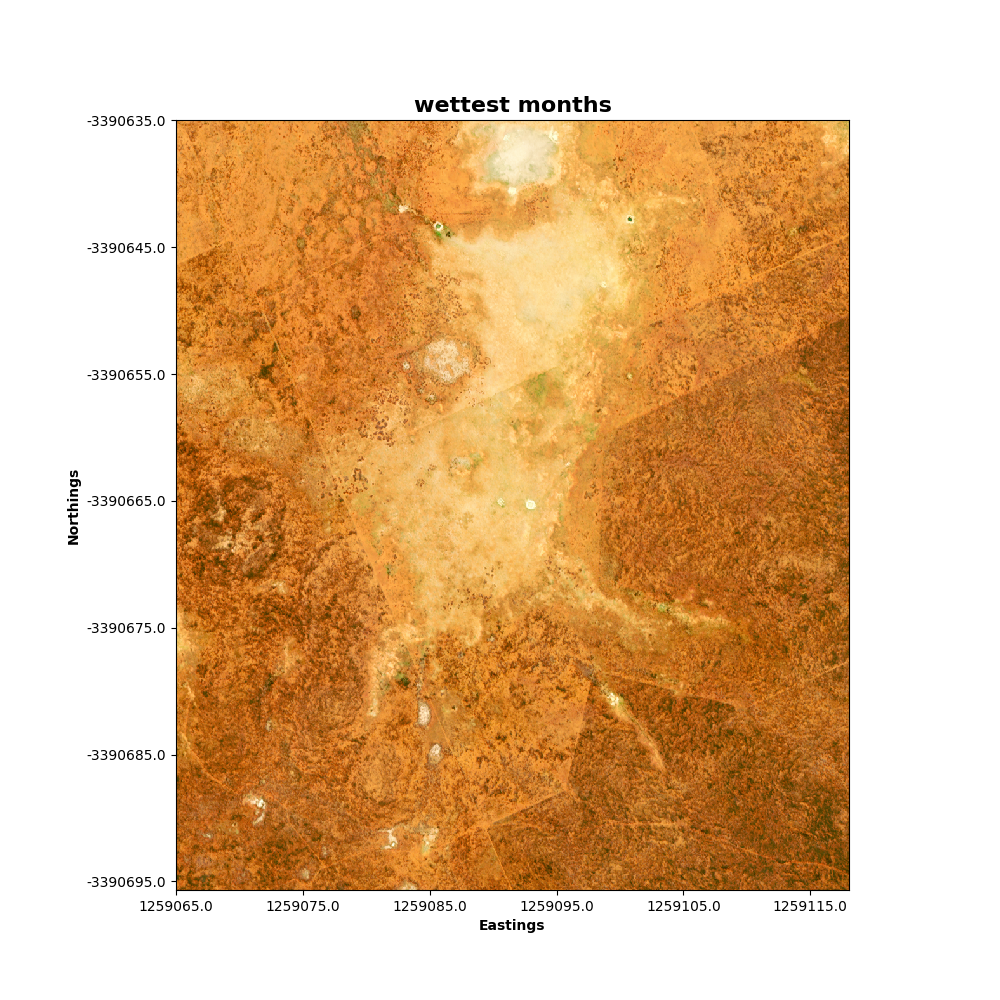

In [17]:
three_band_image_flat(Sentinal_gm_wet, bands=['red','green','blue'], title='wettest months')

<IPython.core.display.Javascript object>


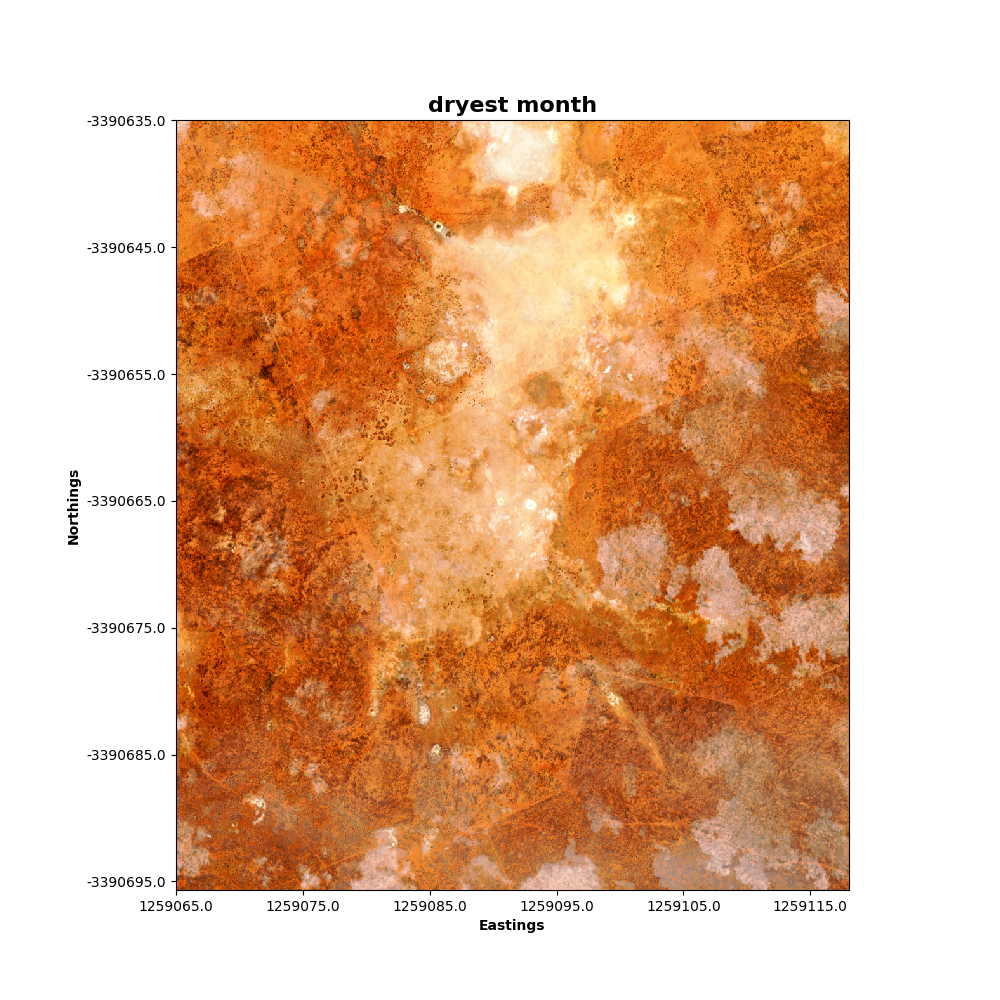

In [18]:
three_band_image_flat(Sentinal_gm_dry, bands=['red','green','blue'], title='dryest month')

In [19]:
wet_NDVI = (Sentinal_gm_wet['nir1']-Sentinal_gm_wet['red'])/(Sentinal_gm_wet['nir1']+Sentinal_gm_wet['red'])
dry_NDVI = (Sentinal_gm_dry['nir1']-Sentinal_gm_dry['red'])/(Sentinal_gm_dry['nir1']+Sentinal_gm_dry['red'])

In [20]:
NDVi_diff = wet_NDVI-dry_NDVI

In [21]:
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

<IPython.core.display.Javascript object>


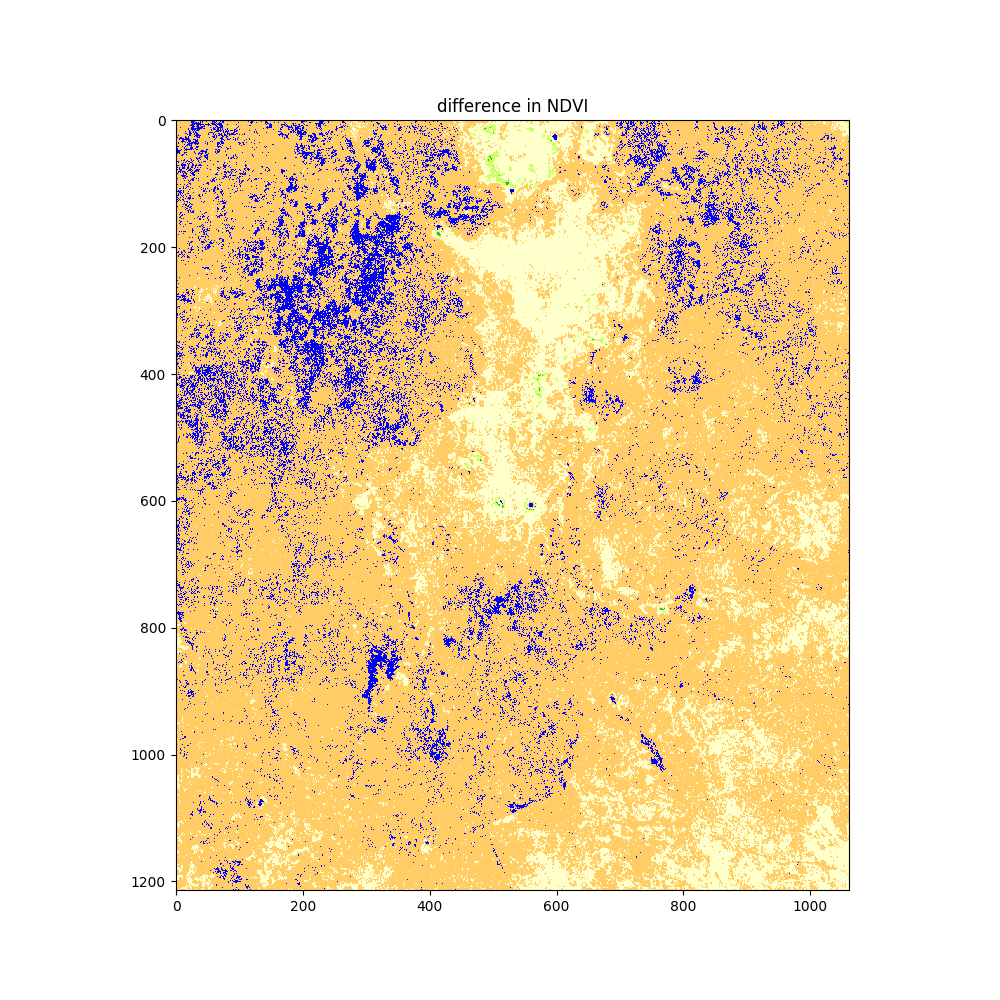

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('difference in NDVI')
ax.imshow(NDVi_diff, cmap = ndvi_cmap, norm = ndvi_norm)

<IPython.core.display.Javascript object>


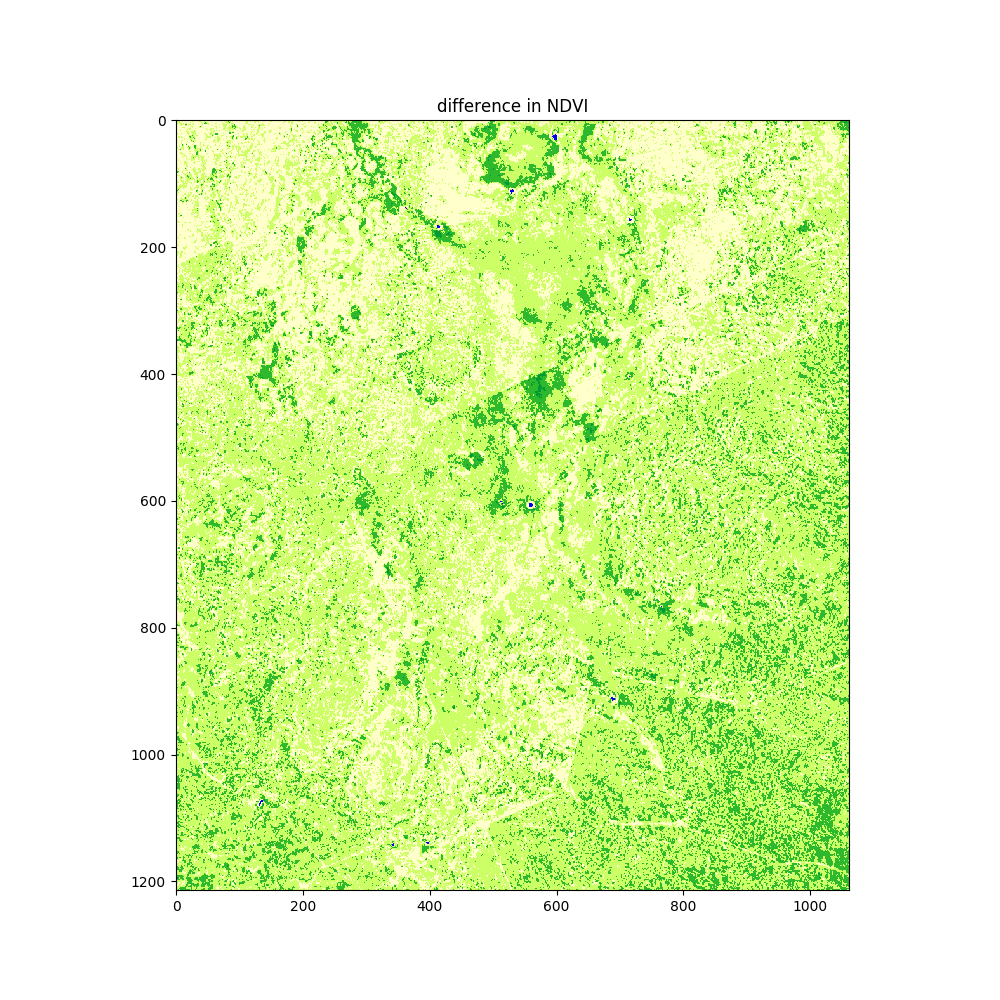

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('difference in NDVI')
ax.imshow(wet_NDVI , cmap = ndvi_cmap, norm = ndvi_norm)